In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
from pathlib import Path
import logging
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import timedelta
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy import stats
import logging
from pathlib import Path
import os
import re

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Define path
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
OUTPUT_DIR = PROJECT_ROOT / "output" 
ABNORMAL_DIR = OUTPUT_DIR / "abnormal_detection_output"

# Create directories if not exist
os.makedirs(DATA_RAW, exist_ok=True)
os.makedirs(DATA_PROCESSED, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(ABNORMAL_DIR, exist_ok=True)



In [2]:
#raw
EVENTS_FILE = DATA_RAW / "events.csv"
ITEM_PROPS_FILE1 = DATA_RAW / "item_properties_part1.csv" 
ITEM_PROPS_FILE2 = DATA_RAW / "item_properties_part2.csv" 
#processed
USER_FEATS_FILE = DATA_PROCESSED / "user_features.csv"
TRANSACTION_FILE = DATA_PROCESSED / "transactions.csv"
ITEM_FILE = DATA_PROCESSED / "item_properties.csv"
EVENTS_PROPS_FILE = DATA_PROCESSED / "events_with_properties.csv"
# anomaly
USER_MODEL = ABNORMAL_DIR / "user_with_models.csv"
USER_RULE = ABNORMAL_DIR / "user_with_rules.csv"
USER_EXTENDED = ABNORMAL_DIR / "user_features_extended.csv"




#### Load raw data

In [3]:
def load_events(path):
    logging.info("Loading events from %s", path)
    df = pd.read_csv(path)
    df['visitorid'] = df['visitorid']
    df['itemid'] = df['itemid']
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df 
def load_item_props(path):
    logging.info("Loading item properties from %s", path)
    df = pd.read_csv(path)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['itemid'] = df['itemid']
    return df
def load(path):
    logging.info("Loading from %s", path)
    df = pd.read_csv(path)
    if 'timestamp'in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    if 'first_event'in df.columns:
        df['first_event'] = pd.to_datetime(df['first_event'])
    if 'last_event'in df.columns:
        df['last_event'] = pd.to_datetime(df['last_event'])
    return df

In [4]:
events_df = load_events(EVENTS_FILE)
item_props_df1 = load_item_props(ITEM_PROPS_FILE1)
item_props_df2 = load_item_props(ITEM_PROPS_FILE2)
item_props_df = pd.concat([item_props_df1, item_props_df2], ignore_index=True)

In [5]:
events_df['timestamp'].dt.date.max()-events_df['timestamp'].dt.date.min()

datetime.timedelta(days=138)

#### Price prediction

In [6]:
def detect_numeric_properties(item_props_df):
    numeric_df = item_props_df[item_props_df['value'].str.startswith('n', na = False)]
    cand = numeric_df.groupby('property').agg(
        n_rows = ('value', 'size'),
        unique_vals = ('value', 'nunique'),
        percentage_only_positive_numvals= ('value', lambda x: \
            sum(bool(re.fullmatch(r"n\d+(\.\d+)?$", v)) for v in x) / len(x) )
    ).reset_index().sort_values('unique_vals', ascending = False)
    cand["percentage of unique vals"] = cand['unique_vals'] / cand['n_rows']
    print("Top numeric property candidates (potential price):")
    print(cand.head(20).to_string(index=False))
    return cand

In [7]:
detect_numeric_properties(item_props_df)

Top numeric property candidates (potential price):
property  n_rows  unique_vals  percentage_only_positive_numvals  percentage of unique vals
     917   91083        84043                          0.855846                   0.922708
     790 1790516        33052                          1.000000                   0.018459
     888  128149        26780                          0.359324                   0.208975
     202   29276        19101                          0.729437                   0.652446
     575   14799        14746                          0.760930                   0.996419
     810   90954         4553                          0.429360                   0.050058
     761   30416         2012                          0.004964                   0.066149
    1066   28476         1350                          0.018893                   0.047408
     400  146749         1142                          0.125296                   0.007782
     566   31148         1035          

,property,n_rows,unique_vals,percentage_only_positive_numvals,percentage of unique vals
495,917,91083,84043,0.855846,0.922708
422,790,1790516,33052,1.000000,0.018459
476,888,128149,26780,0.359324,0.208975
115,202,29276,19101,0.729437,0.652446
302,575,14799,14746,0.760930,0.996419
...,...,...,...,...,...
524,97,5,1,0.000000,0.200000
29,1059,558,1,0.000000,0.001792
5,1007,5,1,0.000000,0.200000
18,1039,7,1,0.000000,0.142857


#### Attach price, available, categoryid into the transactional data

In [8]:
def get_small_props(item_props_df, output = None):
    items_ = item_props_df[
    item_props_df['property'].isin(['790', 'categoryid', 'available'])
    ]
    item_snapshots = items_.pivot_table(
        index=['itemid', 'timestamp'],
        columns='property',
        values='value',
        aggfunc='last'
    ).reset_index()
    item_snapshots = item_snapshots.rename(columns={'790': 'price'})
    item_snapshots['price'] = item_snapshots['price'].str.replace('^n','', regex=True).astype(float)
    if output is not None:
        item_snapshots.to_csv(output, index = False)
    return item_snapshots
def attach_item_properties(events_df, items_props_df, output=None):
    
    events_df = events_df.sort_values(['timestamp', 'itemid'], kind='mergesort').reset_index(drop=True)
    items_props_df = items_props_df.sort_values(['timestamp', 'itemid'], kind='mergesort').reset_index(drop=True)
    merged = pd.merge_asof(
        events_df,
        items_props_df,
        by='itemid',
        left_on='timestamp',
        right_on='timestamp',
        allow_exact_matches=True,
        direction='backward'
    )
    item_means = (
        items_props_df
        .groupby("itemid")  
        .mean(numeric_only=True)  
        .add_prefix("mean_")      
        .reset_index()
    )
    merged = merged.merge(item_means, on="itemid", how="left")
    prop_cols = [
        c for c in items_props_df.columns
        if c not in ["timestamp", "itemid"]
    ]
    for col in prop_cols:
        mean_col = f"mean_{col}"
        if mean_col in merged:
            merged[col] = merged[col].fillna(merged[mean_col])
    if output is not None:
        merged.to_csv(output, index=False)
    return merged


In [9]:
if ITEM_FILE.exists():
    item_props = load(ITEM_FILE)
else:
    item_props = get_small_props(item_props_df, output = ITEM_FILE)

In [10]:
if EVENTS_PROPS_FILE.exists():
    events_with_props = load(EVENTS_PROPS_FILE)
else:
    events_with_props = attach_item_properties(events_df, item_props, output = EVENTS_PROPS_FILE)

#### Get Transactions data only with price

In [11]:
def get_transaction_price(events_with_props, output = None):
    tx = events_with_props[
        events_with_props['event'] == 'transaction'
    ][['timestamp','visitorid','event','itemid','transactionid','price']].copy()

    item_mean_price = (
        tx.loc[tx['price'] > 0]
        .groupby('itemid')['price']
        .mean()
    )

    tx.loc[tx['price'] == 0, 'price'] = (
        tx.loc[tx['price'] == 0, 'itemid']
        .map(item_mean_price)
    )
    print("Number of nan value in price after preprocessing: ",tx['price'].isnull().sum())
    tx = tx.dropna(subset = 'price')
    if output is not None:
        tx.to_csv(output, index = False)
    return tx


In [12]:
if TRANSACTION_FILE.exists():
    tx = load(TRANSACTION_FILE)
else:
    tx = get_transaction_price(events_with_props, output = TRANSACTION_FILE)

#### Build user features

In [13]:
def build_user_features(events_df, cutoff_time=None, output = None):
    print('Building user-level features ...')

    events_df['timestamp'] = pd.to_datetime(events_df['timestamp'], errors='coerce')
    if cutoff_time is None:
        cutoff_time = events_df['timestamp'].max()

    ev = events_df[events_df['timestamp'] <= cutoff_time].copy()
    grp = ev.groupby('visitorid')

    def count_events(df):
        return (
            df['transactionid'].isna().sum() +         # view + addtocart = 1 per row
            df['transactionid'].dropna().nunique()     # transactions = 1 per unique txid
        )
    user_feats = grp.apply(count_events).to_frame('total_events')
    user_feats['first_event'] = grp['timestamp'].min()
    user_feats['last_event'] = grp['timestamp'].max()
    user_feats['first_event'] = pd.to_datetime(user_feats['first_event'])
    user_feats['last_event']  = pd.to_datetime(user_feats['last_event'])

    user_feats['recency_days'] = (cutoff_time - user_feats['last_event']).dt.days
    user_feats['tenure_days'] = (user_feats['last_event'] - user_feats['first_event']).dt.days + 1

    user_feats['total_views'] = grp.apply(lambda g: (g['event'] == 'view').sum())
    user_feats['total_addtocarts'] = grp.apply(lambda g: (g['event'] == 'addtocart').sum())
    user_feats['total_tx'] = grp.apply(lambda g: (g['event'] == 'transaction').sum())

    user_feats['distinct_items'] = grp['itemid'].nunique()
    user_feats['view_items'] = grp.apply(lambda g: g.loc[g['event']=='view','itemid'].nunique())
    user_feats['addtocart_items'] = grp.apply(lambda g: g.loc[g['event']=='addtocart','itemid'].nunique())
    user_feats['tx_items'] = grp.apply(lambda g: g.loc[g['transactionid'].notna(),'itemid'].nunique())

    user_feats['prop_addtocart'] = user_feats['total_addtocarts'] / (user_feats['total_events'] + 1e-9)
    user_feats['prop_tx'] = user_feats['total_tx'] / (user_feats['total_events'] + 1e-9)

    user_feats['events_7d'] = grp.apply(lambda g: count_events(g[g['timestamp'] >= cutoff_time - pd.Timedelta(days=7)]))
    user_feats['events_14d'] = grp.apply(lambda g: count_events(g[g['timestamp'] >= cutoff_time - pd.Timedelta(days=14)]))
    user_feats['events_30d'] = grp.apply(lambda g: count_events(g[g['timestamp'] >= cutoff_time - pd.Timedelta(days=30)]))

    user_feats['active_days'] = grp['timestamp'].apply(lambda s: s.dt.date.nunique())
    user_feats['events_per_active_day'] = user_feats['total_events'] / user_feats['active_days'].replace(0,1)

    user_feats['view_price'] = ev[ev['event']=='view'].groupby('visitorid')['price'].mean()
    user_feats['addtocart_price'] = ev[ev['event']=='addtocart'].groupby('visitorid')['price'].mean()
    user_feats['tx_price'] = ev[ev['event']=='transaction'].groupby('visitorid')['price'].mean()

    def avg_inter_event(s):
        t = s.sort_values()
        if len(t) <= 1:
            return np.nan
        diffs = np.diff(t).astype('timedelta64[s]').astype(float)
        return diffs.mean() / (3600*24)

    user_feats['avg_inter_event_days'] = grp['timestamp'].apply(avg_inter_event)

    user_feats = user_feats.reset_index()

    print(f'Built features for {len(user_feats):,} users')
    if output is not None:
        user_feats.to_csv(output, index = False)
    return user_feats


In [14]:
if USER_FEATS_FILE.exists():
    user_feats = load(USER_FEATS_FILE)
else:
    user_feats = build_user_features(events_with_props)

#### Detect anomaly outlier

In [ ]:
def add_rate_features(events_df):
    df = events_df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    df = df.sort_values(['visitorid', 'timestamp', 'itemid']).reset_index(drop=True)

    # event time differences (seconds) per user
    df['prev_ts'] = df.groupby('visitorid')['timestamp'].shift(1)
    df['delta_s'] = (df['timestamp'] - df['prev_ts']).dt.total_seconds()
    # flag very small inter-event gaps (e.g., < 1s)
    df['very_fast'] = (df['delta_s'] <= 1).astype(int)
    df['very_fast'] = df['very_fast'].fillna(0)

    # repeated same item consecutively
    df['prev_item'] = df.groupby('visitorid')['itemid'].shift(1)
    df['same_item_repeat'] = (df['itemid'] == df['prev_item']).astype(int).fillna(0)

    # number of events per minute per user (rolling)
    df['minute'] = df['timestamp'].dt.floor('T')
    per_min = df.groupby(['visitorid', 'minute']).size().rename('events_per_minute').reset_index()
    df = df.merge(per_min, on=['visitorid','minute'], how='left')
    return df

def compute_extra_user_features(events_df, user_feats):
    ev = add_rate_features(events_df)
    grp = ev.groupby('visitorid')
    
    extra = pd.DataFrame(index=user_feats['visitorid'])
    extra.index.name = 'visitorid'
    extra = extra.reset_index()

    # proportion of very fast events
    prop_fast = grp['very_fast'].mean().rename('prop_very_fast').reset_index()
    extra = extra.merge(prop_fast, on='visitorid', how='left')

    # proportion of consecutive same-item repeats
    prop_repeat = grp['same_item_repeat'].mean().rename('prop_same_item_repeat').reset_index()
    extra = extra.merge(prop_repeat, on='visitorid', how='left')

    # max events per minute observed
    max_epm = grp['events_per_minute'].max().rename('max_events_per_minute').reset_index()
    extra = extra.merge(max_epm, on='visitorid', how='left')

    # distribution of inter-event times: min, median, std
    def secs_stats(s):
        t = s.dropna().astype(float)
        if len(t) == 0:
            return pd.Series({'min_ie_s': np.nan, 'median_ie_s': np.nan, 'std_ie_s': np.nan})
        return pd.Series({'min_ie_s': t.min(), 'median_ie_s': np.median(t), 'std_ie_s': t.std(ddof=0)})
    ie_stats = grp['delta_s'].apply(secs_stats).reset_index()
    extra = extra.merge(ie_stats, on='visitorid', how='left')

    # fraction of events that have price available (non-null price)
    price_avail = ev['price'].notna().groupby(ev['visitorid']).mean().rename('prop_price_available').reset_index()
    extra = extra.merge(price_avail, on='visitorid', how='left')

    # fillna
    extra = extra.fillna(0)

    # join to user_feats
    merged = user_feats.merge(extra, on='visitorid', how='left')
    # ensure numeric types
    numeric_cols = merged.select_dtypes(include=['float64','int64']).columns
    merged[numeric_cols] = merged[numeric_cols].fillna(0)

    return merged

def rule_based_flags(df, verbose=False):

    out = df.copy()

    TH_EVENTS = 6000              # extremely many events overall
    TH_EVENTS_PER_DAY = 500       # many events per single active day
    TH_EP_MIN = 50                # events per minute peak
    TH_PROP_FAST = 0.5            # >50% events with <=1s gap
    TH_PROP_REPEAT = 0.5          # >50% consecutive same item
    TH_DISTINCT_ITEMS = 3000       # many distinct items
    TH_EVENTS_30D = 1000           # many events in last 30d

    out['flag_many_events'] = (out['total_events'] >= TH_EVENTS).astype(int)
    out['flag_many_events_30d'] = (out['events_30d'] >= TH_EVENTS_30D).astype(int)
    out['flag_events_per_day_high'] = (out['events_per_active_day'] >= TH_EVENTS_PER_DAY).astype(int)
    out['flag_high_epm'] = (out['max_events_per_minute'] >= TH_EP_MIN).astype(int)
    out['flag_fast_burst'] = (out['prop_very_fast'] >= TH_PROP_FAST).astype(int)
    out['flag_repeat_items'] = (out['prop_same_item_repeat'] >= TH_PROP_REPEAT).astype(int)
    out['flag_many_distinct_items'] = (out['distinct_items'] >= TH_DISTINCT_ITEMS).astype(int)

    flag_cols = [c for c in out.columns if c.startswith('flag_')]
    out['rule_flag_score'] = out[flag_cols].sum(axis=1)

    if verbose:
        print('Rule thresholds:')
        print(f' TH_EVENTS={TH_EVENTS}, TH_EVENTS_PER_DAY={TH_EVENTS_PER_DAY}, TH_EP_MIN={TH_EP_MIN}')
        print(f' TH_PROP_FAST={TH_PROP_FAST}, TH_PROP_REPEAT={TH_PROP_REPEAT}, TH_DISTINCT_ITEMS={TH_DISTINCT_ITEMS}')
        print('Top rule-flagged users:')
    return out

def model_based_flags(df, model_seed=42, n_estimators=100):
    features = [
        'events_7d',
        'events_30d',
        'prop_addtocart',
        'prop_tx',
        'events_per_active_day'
    ]
    features = [f for f in features if f in df.columns]

    X = df[features].fillna(0).astype(float).values

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    iso = IsolationForest(
        n_estimators=n_estimators,
        contamination=0.00001,      
        random_state=model_seed,
        n_jobs= -3      
    )
    iso.fit(Xs)

    iso_scores = iso.decision_function(Xs)
    iso_pred   = iso.predict(Xs)

    out = df.copy()
    out['iso_score'] = iso_scores
    out['iso_flag'] = (iso_pred == -1).astype(int)

    a = iso_scores
    if a.max() == a.min():
        out['iso_score_norm'] = 0
    else:
        out['iso_score_norm'] = 1 - (a - a.min()) / (a.max() - a.min())
    out['model_flag'] = (out['iso_score_norm'] >= 0.6).astype(int)
    return out

def plot_feature_distributions(df, features, n_cols=3, figsize=(15,10), log_transform=None):

    n = len(features)
    n_rows = int(np.ceil(n / n_cols))
    plt.figure(figsize=figsize)
    for i, f in enumerate(features, 1):
        plt.subplot(n_rows, n_cols, i)
        series = df[f].dropna()
        if log_transform and f in log_transform:
            series = series[series > 0]
            plt.hist(np.log1p(series), bins=50)
            plt.title(f'{f} (log1p)')
            plt.xlabel('log1p(value)')
        else:
            plt.hist(series, bins=50)
            plt.title(f'{f}')
        plt.tight_layout()
    plt.show()
def plot_top_flagged_users(df, top_n=30, sort_by='rule_flag_score'):

    top = df.sort_values([sort_by,'total_events'], ascending=[False, False]).head(top_n)
    plt.figure(figsize=(12,6))
    sns.barplot(x=top['visitorid'].astype(str), y=top[sort_by])
    plt.xticks(rotation=90)
    plt.title(f'Top {top_n} users by {sort_by}')
    plt.xlabel('visitorid')
    plt.ylabel(sort_by)
    plt.show()


In [16]:
def run_pipeline(events, user_feats, cutoff_time=None, sample_frac=None):

    # compute extra features from event-level behaviour (fast bursts, repeats, epm)
    if USER_EXTENDED.exists():
        user_feats_ext = load(USER_EXTENDED)
    else:
        user_feats_ext = compute_extra_user_features(events, user_feats)
        user_feats_ext.to_csv(USER_EXTENDED, index=False)

    # rule-based flags
    if USER_RULE.exists():
        user_with_rules = load(USER_RULE)
    else: 
        user_with_rules = rule_based_flags(user_feats_ext, verbose=True)
        user_with_rules.to_csv(USER_RULE, index=False)

    #  model-based flags
    if USER_MODEL.exists():
        user_with_models = load(USER_MODEL)
    else:
        user_with_models = model_based_flags(user_with_rules)
        user_with_models.to_csv(USER_MODEL, index=False)

    # combined scoring
    W_RULE = 0.6
    W_MODEL = 0.4

    # normalize rule score
    max_rule = user_with_models['rule_flag_score'].max() if user_with_models['rule_flag_score'].max() > 0 else 1
    user_with_models['rule_score_norm'] = user_with_models['rule_flag_score'] / max_rule
    user_with_models['combined_score'] = W_RULE * user_with_models['rule_score_norm'] + W_MODEL * user_with_models['iso_score_norm']

    # final binary flag
    FINAL_THRESHOLD = 0.5 
    user_with_models['final_flag'] = (user_with_models['combined_score'] >= FINAL_THRESHOLD).astype(int)

    user_with_models.to_csv(ABNORMAL_DIR /'user_abnormal_flags_final.csv', index=False)

    print('Summary of flagged users:')
    print(user_with_models['final_flag'].value_counts())

    # visualizations for inspection
    features_to_plot = [
        'total_events','events_per_active_day','max_events_per_minute',
        'prop_very_fast','prop_same_item_repeat','distinct_items','combined_model_score','rule_flag_score','combined_score'
    ]
    features_exist = [f for f in features_to_plot if f in user_with_models.columns]
    plot_feature_distributions(user_with_models, features_exist, n_cols=3, figsize=(14,10), log_transform=['total_events','distinct_items'])

    # plot top flagged users
    plot_top_flagged_users(user_with_models, top_n=25, sort_by='combined_score')

    # export sample of flagged users for manual inspection (most useful)
    flagged = user_with_models[user_with_models['final_flag'] == 1].copy()
    flagged = flagged.sort_values(['combined_score','rule_flag_score','total_events'], ascending=[False, False, False])
    sample_flagged = flagged.head(200)
    sample_flagged.to_csv(ABNORMAL_DIR / 'flagged_users_sample.csv', index=False)
    print('Wrote top 200 flagged users to flagged_users_sample.csv')

    return user_with_models, events


Summary of flagged users:
final_flag
0    4203057
1      19683
Name: count, dtype: int64


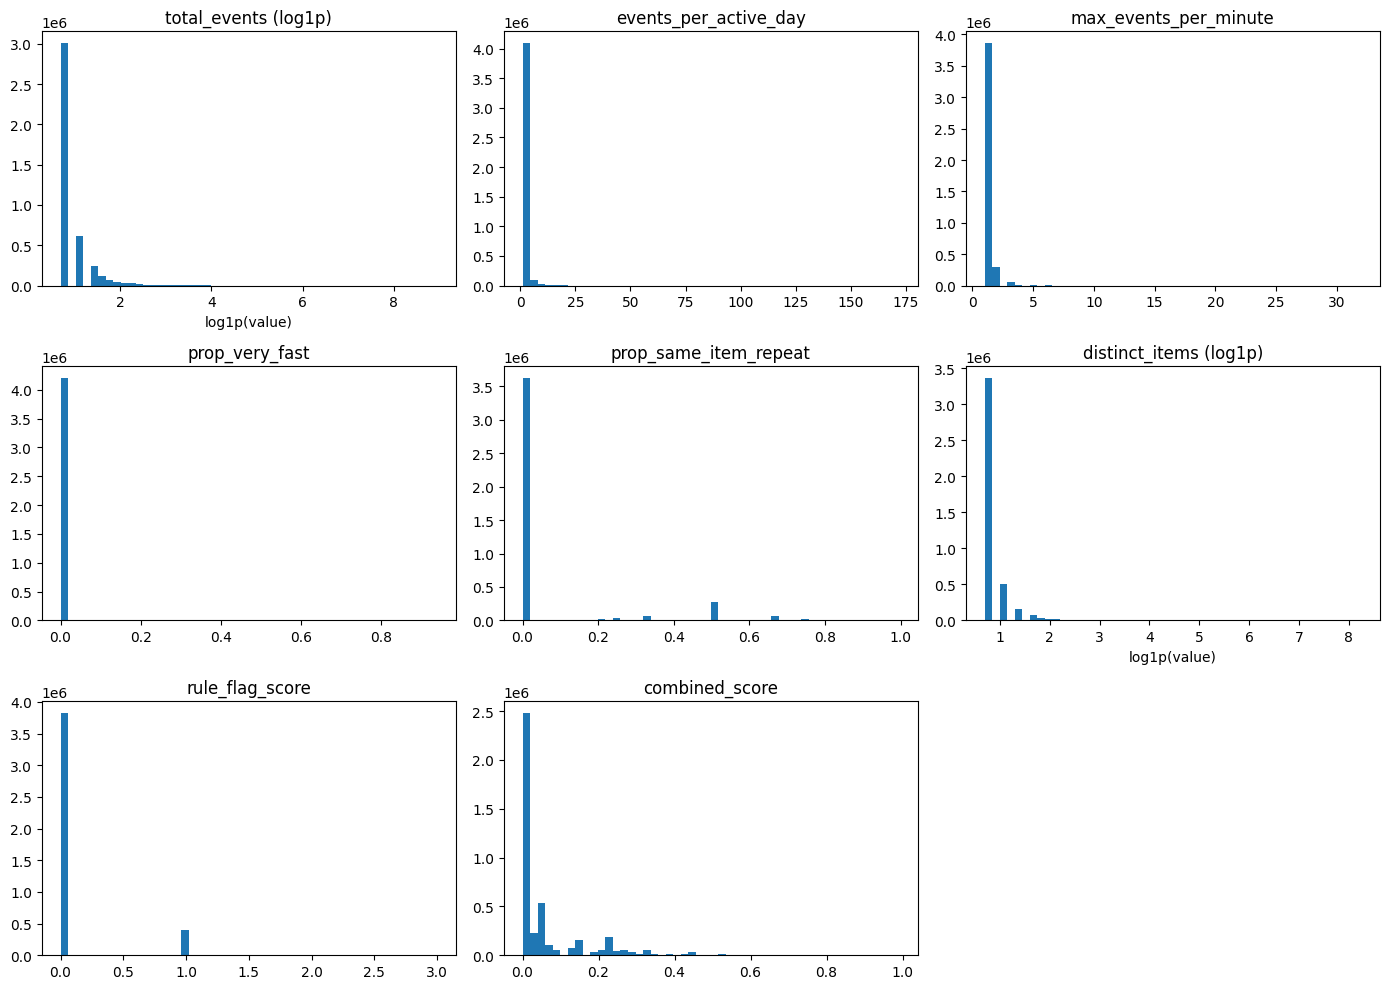

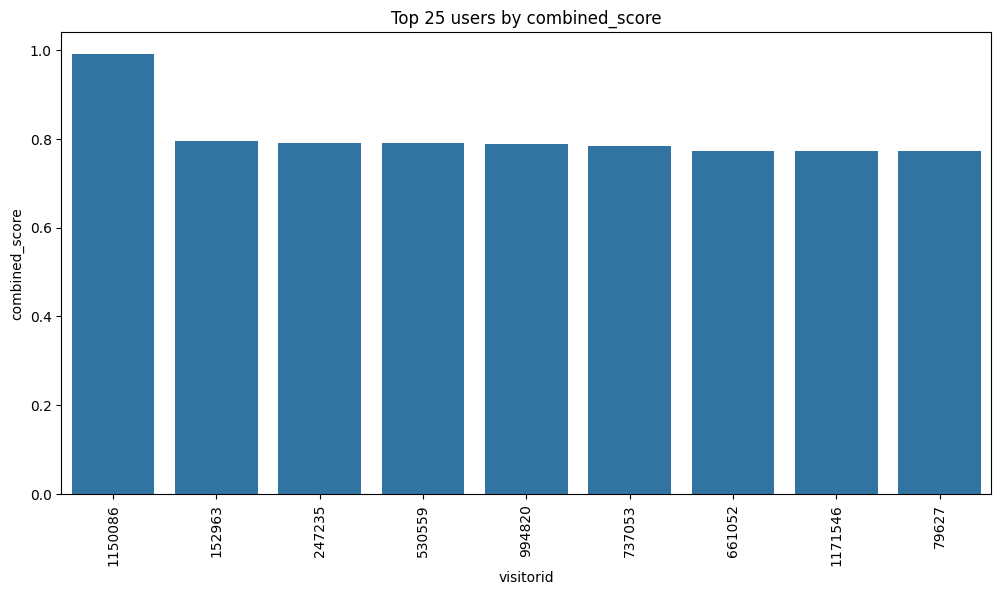

Wrote top 200 flagged users to flagged_users_sample.csv


In [17]:
CUTOFF_TIME = None
SAMPLE_FRAC = None
user_flags, events_df = run_pipeline(
        events_df,
        user_feats,
        cutoff_time=CUTOFF_TIME,
        sample_frac=SAMPLE_FRAC
    )

In [18]:
user_flags[user_flags['visitorid'] == 1150086].iloc[0]

Unnamed: 0                                     1150086
visitorid                                      1150086
total_events                                      7700
first_event                 2015-06-11 14:55:17.389000
last_event                  2015-09-17 02:57:11.237000
recency_days                                         1
tenure_days                                         98
total_views                                       6479
total_addtocarts                                   719
total_tx                                           559
distinct_items                                    3814
view_items                                        3809
addtocart_items                                    623
tx_items                                           532
prop_addtocart                                0.093377
prop_tx                                       0.072597
events_7d                                          233
events_14d                                         762
events_30d

#### REMOVE OUTLIER

In [19]:
# remove visitorid = 1150086
REMOVE_ID = 1150086
events_with_props = events_with_props[events_with_props['visitorid'] != REMOVE_ID] 
tx = tx[tx['visitorid'] != REMOVE_ID]
user_feats = user_feats[user_feats['visitorid'] != REMOVE_ID]

# save back to CSV
events_with_props.to_csv(EVENTS_PROPS_FILE, index=False)
tx.to_csv(TRANSACTION_FILE, index=False)
user_feats.to_csv(USER_FEATS_FILE, index=False)
